In [1]:
import pandas as pd
df = pd.read_csv(r"C:\\Users\\JellevanAs\\Documents\\Studie\\Thesis\\df-BERT_eng.csv")
df.columns.tolist()

['url',
 'price',
 'address',
 'descrip',
 'listed_since',
 'zip_code',
 'size',
 'year',
 'living_area',
 'kind_of_house',
 'building_type',
 'num_of_rooms',
 'num_of_bathrooms',
 'layout',
 'energy_label',
 'insulation',
 'heating',
 'ownership',
 'exteriors',
 'parking',
 'date_list',
 'last_ask_price',
 'last_ask_price_m2',
 'city',
 'log_id',
 'num of tokens per descrip',
 'descrip_en',
 'numerical_price',
 'numerical_price_per_m2',
 'tag',
 'house_category',
 'living_area_float',
 'size_float',
 'zip_code_4_digits',
 'postcode',
 'latitude',
 'longitude',
 'embeddings']

In [2]:
print(df['embeddings'].head())


0    [-0.10525031387805939, 0.10118187963962555, 0....
1    [-0.30174195766448975, 0.11353027820587158, 0....
2    [-0.27580368518829346, 0.05323677882552147, 0....
3    [-0.08905467391014099, 0.12471916526556015, 0....
4    [-0.2315809726715088, -0.056568291038274765, 0...
Name: embeddings, dtype: object


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval


df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

x = df["embeddings"]
y = df['numerical_price']
x = x.apply(pd.Series)


# Explode the embedding arrays into separate rows


In [4]:
print(type(df['embeddings'][0]))


<class 'numpy.ndarray'>


In [5]:
print(df['embeddings'][0].shape)
print(df['embeddings'][0])


(768,)
[-1.05250314e-01  1.01181880e-01  6.72082722e-01 -7.33218342e-02
  5.61478555e-01 -4.28940393e-02 -1.08725101e-01  3.16940635e-01
 -2.15859070e-01 -4.66211677e-01 -7.16900378e-02 -4.94034469e-01
 -1.06710054e-01  2.37510845e-01 -1.51344150e-01  3.30404848e-01
  4.60984260e-01  9.94020477e-02 -2.33538225e-01  2.67215103e-01
  3.02671731e-01 -6.23341370e-03  1.46885246e-01  3.70972484e-01
  3.78026515e-01 -7.83415660e-02  1.63703933e-01  1.03531353e-01
  6.06879927e-02 -1.16071321e-01  5.18190026e-01  1.10459104e-01
 -2.12041419e-02 -3.31873775e-01  1.80991173e-01 -1.05725199e-01
 -5.80746830e-02 -2.64098376e-01 -1.27479941e-01  9.83197168e-02
 -3.16381127e-01 -2.04686284e-01  3.57754156e-02 -1.06991706e-02
 -1.89486668e-01 -2.88048029e-01  2.80486465e-01 -9.92657170e-02
  4.30991780e-03 -1.62108585e-01 -3.28258216e-01  8.84870961e-02
 -1.70754141e-03  8.09591711e-02  3.86370599e-01  5.73663771e-01
 -2.22106665e-01 -1.92107484e-01 -2.22602293e-01 -1.27975389e-01
  1.97737172e-01 -

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [7]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_linear_svr(trial):
    # Parameters for LinearSVR
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
    tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)
    loss = trial.suggest_categorical("loss", ['epsilon_insensitive', 'squared_epsilon_insensitive'])

    # Ensure compatible settings for dual and loss
    if loss == 'epsilon_insensitive':
        dual = True  # dual must be True for 'epsilon_insensitive'
    else:
        dual = trial.suggest_categorical("dual", [True, False])

    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_uniform("intercept_scaling", 0.1, 10)
    max_iter = trial.suggest_int("max_iter", 1000, 10000)

    linear_svr_params = dict(C=C, epsilon=epsilon, tol=tol, loss=loss, 
                             fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, 
                             dual=dual, max_iter=max_iter)

    clf_linear_svr = LinearSVR(**linear_svr_params, random_state=0)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(y_train_fold.values.reshape(-1, 1))
        y_train_scaled = y_train_scaled.ravel()

        # Fitting the model
        clf_linear_svr.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_linear_svr.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)


    return float(np.mean(r2_scores))


C:\Users\JellevanAs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_linear_svr, n_trials=50)

[I 2024-01-07 00:28:40,518] A new study created in memory with name: no-name-55d0f1a9-23df-4502-bfb3-83988a3a0ab0
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\3605284942.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\3605284942.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\3605284942.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\1580732517.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\1580732517.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_19756\1580732517.py:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


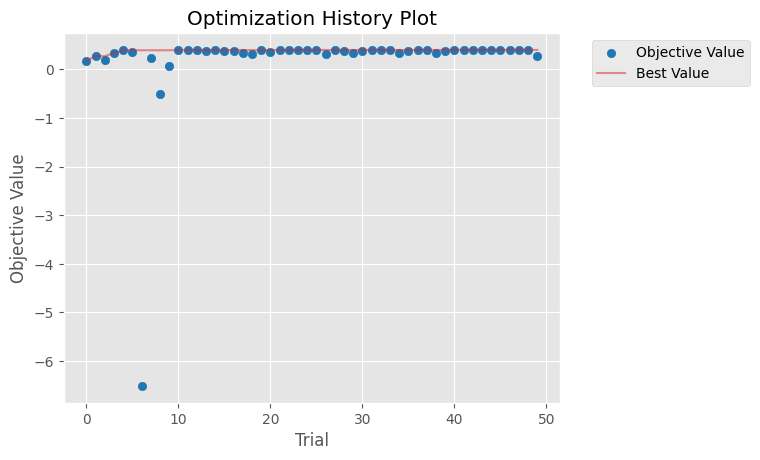

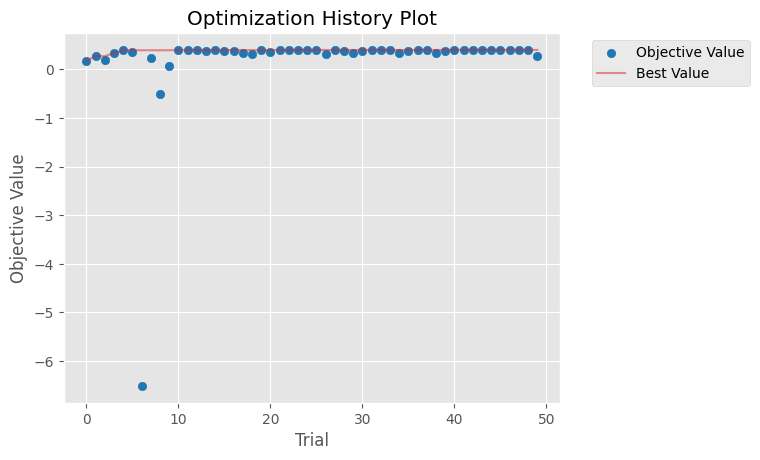

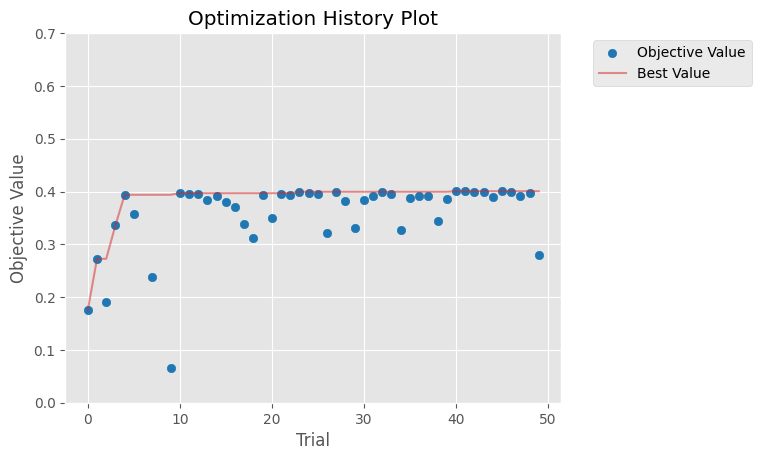

In [9]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 0.7)

plt.show()